# **CSCI 485 Assignment #5: SVD**

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## **Part 1: Preprocessing**
---

The following code reads the `image.jpg` file and converts it to grayscale. The dimensions were printed to ensure no cropping was needed, as the image is already 256x256.

Image Dimensions: 512 x 512


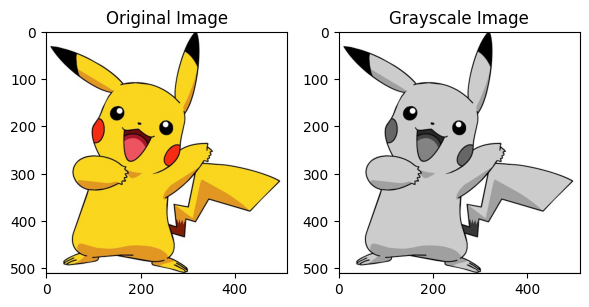

In [84]:

img = Image.open('image.png').convert('RGB')
print(f"Image Dimensions: {img.size[0]} x {img.size[1]}")

grey_img = img.convert('L')

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(grey_img, cmap='gray')

plt.tight_layout()
plt.show()


## **Part 2: Block-wise SVD Function**
---

The `compress_block(block, k)` function takes in a matrix block and compresses it using SVD. The block is decomposed into three components:

* `U`: an orthogonal matrix representing the column space (8×8),
* `S`: a vector of singular values that represent the importance scores (length-8),
* `VT`: an orthogonal matrix representing the row space (8×8).

The parameter `full_matrices=False` ensures that a more efficient SVD algorithm is used, where the shapes of the matrices are limited to `k` rather than the full dimensions `m` and `n`.

The function then reconstructs the block using only the top-`k` singular values and their corresponding vectors from `U` and `VT`, returning a compressed approximation of the original block.

The `compress_image(img, k)` function is the main function that calls the `compress_block(block, k)` function to compress all the 8x8 blocks of the original image and reconstructs the image in the correct order of the blocks' placement.

In [85]:
def compress_block(block, k):
    U, S, VT = np.linalg.svd(block, full_matrices=False)
    block_k = U[:, :k] @ np.diag(S[:k]) @ VT[:k, :]
    return block_k

def compress_image(img, k):
    # Create an array to hold the reconstructed image
    reconstructed_img = np.zeros_like(img, dtype=float)
    
    # Process each 8x8 block
    for i in range(0, img.shape[0], 8):
        for j in range(0, img.shape[1], 8):
            block = img[i:i+8, j:j+8].astype(float)  
            compressed_block = compress_block(block, k)
            reconstructed_img[i:i+8, j:j+8] = compressed_block 

    return reconstructed_img

## **Part 3: Compression Analysis**
---

Now that the compression function has been defined, the following code compresses the original image using different `k` values from 1 to 8. It then plots the reconstructed images to show the differences, along with the compression ratios, reconstruction errors using the Frobenius norm, and peak signal-to-noise ratio (PSNR), which are saved for further analysis in the next section.

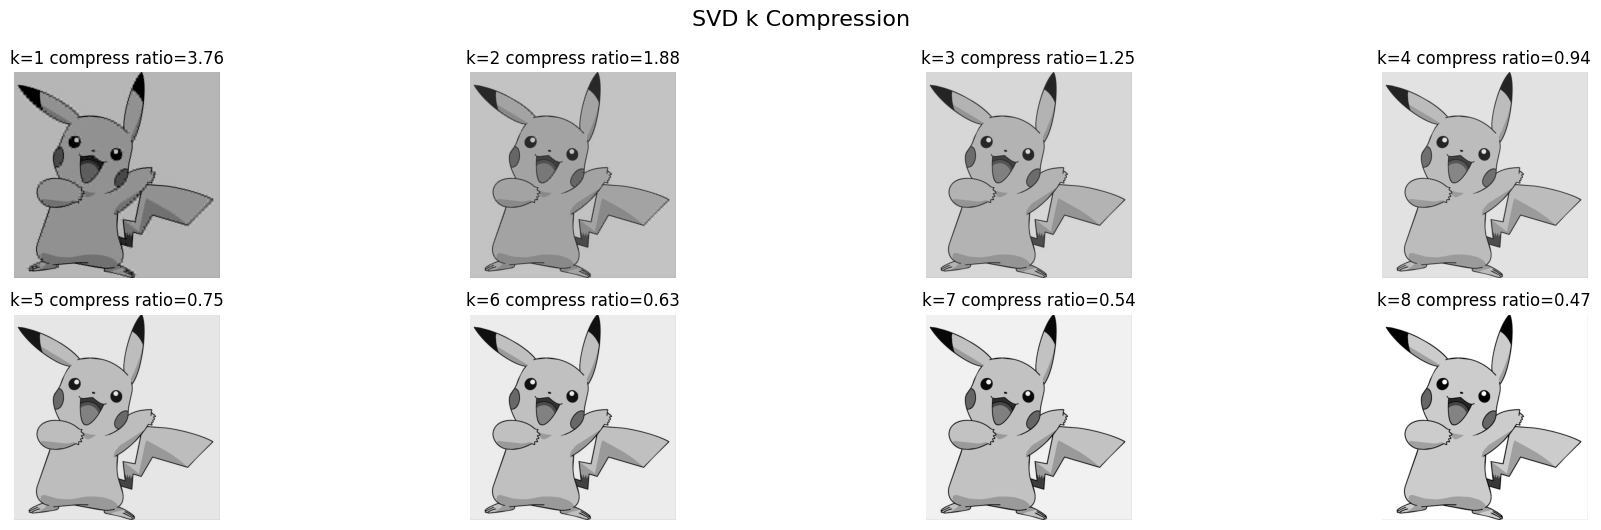

In [86]:
compression_ratios = []
errors = []
PSNRs = []
grey_img_np = np.array(grey_img, dtype=np.float64)

plt.figure(figsize=(20, 5))
for k in range(1, 9):
    reconstructed_img = compress_image(grey_img_np, k)

    ratio = 64 / (k*(8+8+1))
    error = np.linalg.norm(grey_img_np.astype(float) - reconstructed_img, 'fro')
    mse = (error**2) / (img.size[0] * img.size[1])
    psnr = 20 * np.log10(255 / np.sqrt(mse))
    compression_ratios.append(ratio)
    errors.append(error)
    PSNRs.append(psnr)

    plt.subplot(2, 4, k)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title(f'k={k} compress ratio={ratio:.2f}')
    plt.axis('off')
    
plt.tight_layout()
plt.suptitle("SVD k Compression", fontsize=16, y=1.05)
plt.show()

The results show that the higher the `k` value, the closer the reconstructed image is to the original. By `k = 3`, the edges of the image are visually noticeably sharper, resembling the original image. However, it isn't until `k = 8` that the overall background appears white, as in the original image. This could be because the singular values corresponding to the background pixels are relatively small compared to those representing more prominent features, such as edges.



## **Part 4: Visualization**
---

The visualization below shows the compression ratio compared to its corresponding `k` value. The compression ratio is calculated by dividing the original data per block by the data retained per block after applying the top-`k` singular values. Since the overall image is divided into 8×8 blocks, the original data per block is 8×8 = 64. After applying SVD and keeping only the top-k components, the retained data per block is based on the sizes of the `U`, `S`, and `Vᵀ` matrices. For compressing an 8×8 block with a given `k`, the dimensions are `(U: 8*k, S: k, Vᵀ: k*8)`, which results in a total retained size of `k * (8 + 8 + 1)`.

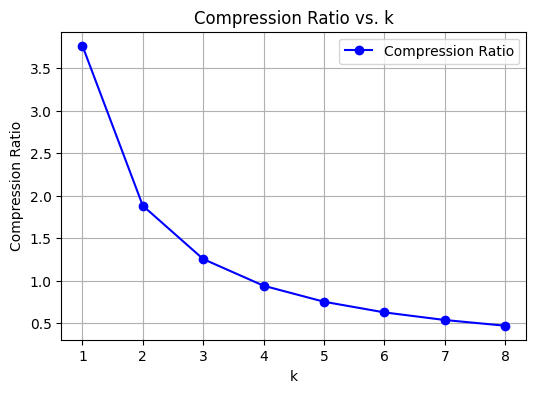

In [87]:
ks = list(range(1, 9))
plt.figure(figsize=(6, 4))
plt.plot(ks, compression_ratios, 'bo-', label='Compression Ratio')
plt.title('Compression Ratio vs. k')
plt.xlabel('k')
plt.ylabel('Compression Ratio')
plt.grid(True)
plt.legend()

The visualization shows a steep decrease in compression ratio initially, followed by a more gradual decline as `k` approaches 8. In the previous section, I noted that by `k = 3`, the edges of the reconstructed image appeared nearly as sharp as the original image. This aligns with the sharp drop in compression ratio seen in the plot. As `k` increases beyond 3, the only noticeable visual difference is the background gradually becoming lighter, eventually appearing white at `k = 8`. This suggests that the compression gains from higher `k` values are relatively minor, as there are no significant changes in image quality after `k = 3`, aside from subtle enhancements in the background.

To calculate how different the reconstructed image is from the original, the Frobenius Norm was used to evaluate the reconstruction error. The Frobenius Norm is a method that computes the overall difference between the original and reconstructed images by comparing them pixel by pixel. Using this metric allows for a more accurate assessment of the reconstructed image’s quality compared to relying solely on visual inspection.

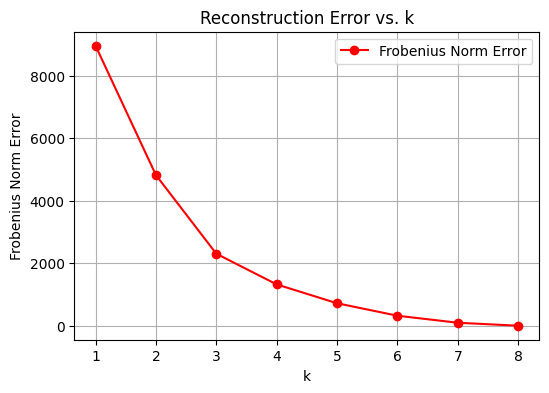

In [88]:
plt.figure(figsize=(6, 4))
plt.plot(ks, errors, 'ro-', label='Frobenius Norm Error')
plt.title('Reconstruction Error vs. k')
plt.xlabel('k')
plt.ylabel('Frobenius Norm Error')
plt.grid(True)
plt.legend()

The path of the visualization seems to be correlated with the compression ratio vs. k graph. This makes sense, as the higher the `k` value, the more information is being stored from the original image—but it also means less information is being lost during reconstruction. Again, there's a steeper decline up to `k = 3`, then a more steady drop afterward. This could be because, by `k = 3`, the reconstruction already captures the image's edges well, and the following `k` values focus more on refining the background details.



Peak Signal-to-Noise Ratio (PSNR) is another metric that can be used to assess the quality of a reconstructed image compared to the original. It essentially measures the ratio between the maximum possible power of a signal and the power of the corrupting noise. In this case, the maximum possible power of the signal is 255, since that’s the highest pixel intensity for a grayscale image. The power of the corrupting noise is the Mean Squared Error (MSE) between the reconstructed and original image. The following is the equation used to calculate PSNR, which was applied in the code from the previous section.

$\text{PSNR} = 20 \cdot \log_{10} \left( \frac{MAX}{\sqrt{\text{MSE}}} \right)$

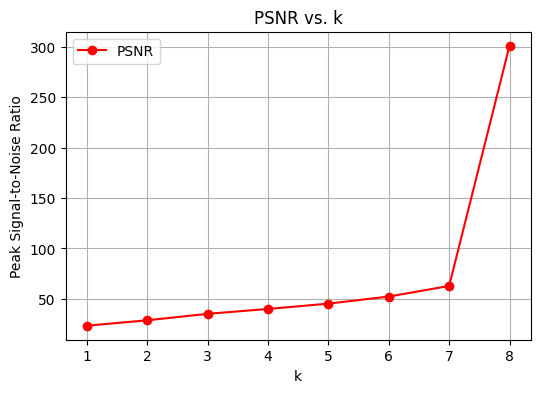

In [89]:
plt.figure(figsize=(6, 4))
plt.plot(ks, PSNRs, 'ro-', label='PSNR')
plt.title('PSNR vs. k')
plt.xlabel('k')
plt.ylabel('Peak Signal-to-Noise Ratio')
plt.grid(True)
plt.legend()

The resulting figure shows that as `k` increases, so does the PSNR. This is expected because higher PSNR values represent better quality by reducing noise. However, I didn’t expect `k` values from 1 through 7 to increase at a steady, similar slope—especially given my results from the Frobenius Norm and Compression Ratio. I expected a steeper increase from k = 1 through 3, just like in the other figures. My reasoning behind this result is that since PSNR is a different method for calculating the quality of the reconstructed image, it most likely captures the differences in a more normalized way—where differences in edges and background are given the same weight in terms of how much noise they contribute to the reconstructed image. That’s why it steadily increases at a similar rate from k = 1 through 7, but then shoots straight up at `k = 8`, because that’s when it uses all the singular values available to fully represent the original 8×8 block.